# Anomaly Finder API Example

### This Jupyter notebook shows you how to get started with the Anomaly Finder API in Python, and how to visualize your results.

In [1]:
import requests
import json
import pandas as pd
import numpy as np
from __future__ import print_function
from datetime import datetime, date
import pytz
from dateutil import parser

# Import library to display results
import matplotlib.pyplot as plt
%matplotlib inline 

## Find anomalies of sample timeseries in batch

In [2]:
# Variables
endpoint = 'https://westus2.api.cognitive.microsoft.com/anomalyfinder/v2.0/timeseries/entire/detect'
subscription_key = '' #Here you have to paste your primary key

In [3]:
def detect(endpoint , subscription_key, request_data):
    headers = {'Content-Type': 'application/json', 'Ocp-Apim-Subscription-Key': subscription_key}
    response = requests.post(endpoint, data=json.dumps(request_data), headers=headers)
    if response.status_code == 200:
        return json.loads(response.content.decode("utf-8"))
    else:
        print(response.status_code)
        raise Exception(response.text)

sample_data = json.load(open('sample.json'))
result = detect(endpoint, subscription_key, sample_data)

In [4]:
def tune(sensitivity, response):
    plt.figure(figsize=(20,10))
    values = response['Value'].tolist()
    anomaly_labels = []
    label = response['Timestamp'].tolist()
    anomlies = []
    index = 0
    anoms = 0
    for anom in response['IsAnomaly']:
        if anom == True and (values[index] > response.iloc[index]['ExpectedValues'] + 
                         (100 - sensitivity)*response.iloc[index]['UpperMargins']  or 
                         values[index] < response.iloc[index]['ExpectedValues'] - 
                         (100 - sensitivity)*response.iloc[index]['LowerMargins']):
            anomlies.append(values[index])
            anoms = anoms + 1
        else:
            anomlies.append(None)
        index = index+1
    
    print('Anomaly Count is : {0}'.format(anoms))
    plt.plot(label, values, label='Value')
    plt.scatter(label, anomlies, marker='o', color='r')
    plt.plot(label, response['ExpectedValues'])
    # plt.plot(label, response['ExpectedValues'] + (100-sensitivity)*response['UpperMargins'], label='Upper',linestyle='--', linewidth=1)
    # plt.plot(label, response['ExpectedValues'] - (100-sensitivity)*response['LowerMargins'], label='Lower', linestyle='--', linewidth=1)
    plt.legend(shadow=True, fancybox=True)

Anomaly Count is : 15


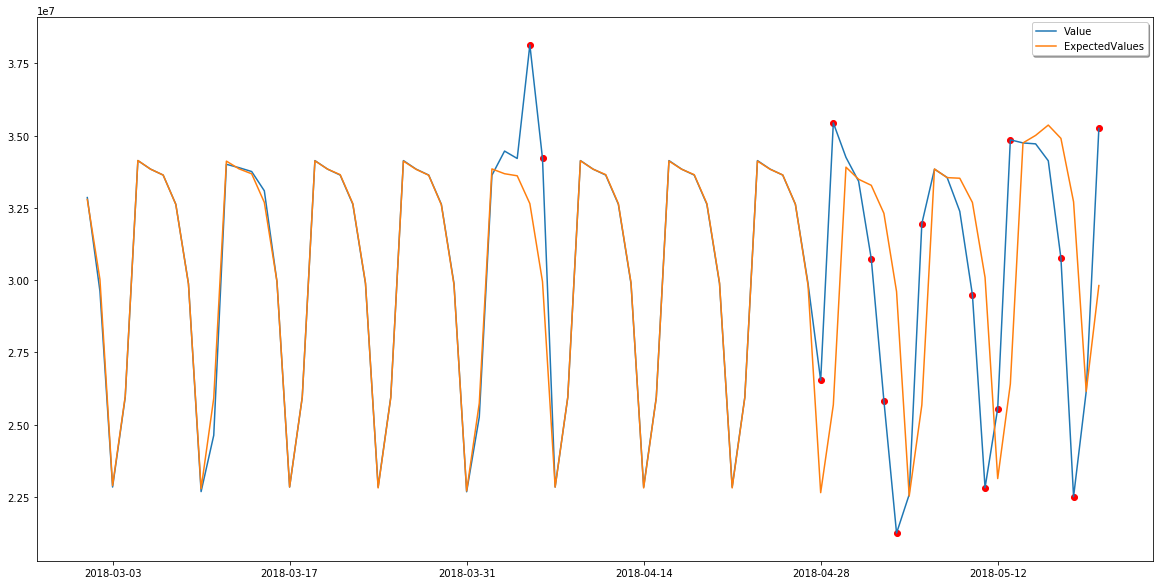

In [5]:
columns = {'ExpectedValues': result['ExpectedValues'], 'IsAnomaly': result['IsAnomaly'], 'IsAnomaly_Neg': result['IsNegativeAnomaly'],
              'IsAnomaly_Pos': result['IsPositiveAnomaly'], 'UpperMargins': result['UpperMargins'], 'LowerMargins': result['LowerMargins']
              , 'Value': [x['Value'] for x in sample_data['Series']], 'Timestamp': [parser.parse(x['Timestamp']) for x in sample_data['Series']]}
response = pd.DataFrame(data=columns)
sensitivity = 95 # you can change sensitivity here to tune upper and lower boundary
tune(sensitivity, response)

## Detect latest anomaly of sample timeseries

Find anomalies in batch will detect all points with same model, this method can not adapt to series pattern's change well.
Usually, for online monitoring scenario, user can choose to detect latest one with a limited window size series, in the belowing
example, we simulte a streaming scenario, each time we detect the latest one with 29 points before. (since period of the series is 7). 

In [6]:
# Variables
endpoint = 'https://westus2.api.cognitive.microsoft.com/anomalyfinder/v2.0/timeseries/last/detect'
subscription_key = '' #Here you have to paste your primary key

In [7]:
sample_data = json.load(open('sample.json'))
points = sample_data['Series']
skip_point = 29
result = {'ExpectedValues': [None]*len(points), 'UpperMargins': [None]*len(points), 
          'LowerMargins': [None]*len(points), 'IsNegativeAnomaly': [False]*len(points), 
          'IsPositiveAnomaly':[False]*len(points), 'IsAnomaly': [False]*len(points)}
anom_count = 0
for i in range(skip_point, len(points)+1):
    single_sample_data = {}
    single_sample_data['Series'] = points[i-29:i]
    single_sample_data['Granularity'] = 'daily'
    single_sample_data['MaxAnomalyRatio'] = 0.25
    single_point = detect(endpoint, subscription_key, single_sample_data)
    if single_point['IsAnomaly'] == True:
        anom_count = anom_count + 1
    result['ExpectedValues'][i-1] = single_point['ExpectedValue']
    result['UpperMargins'][i-1] = single_point['UpperMargin']
    result['LowerMargins'][i-1] = single_point['LowerMargin']
    result['IsNegativeAnomaly'][i-1] = single_point['IsNegativeAnomaly']
    result['IsPositiveAnomaly'][i-1] = single_point['IsPositiveAnomaly']
    result['IsAnomaly'][i-1] = single_point['IsAnomaly']

Anomaly Count is : 9


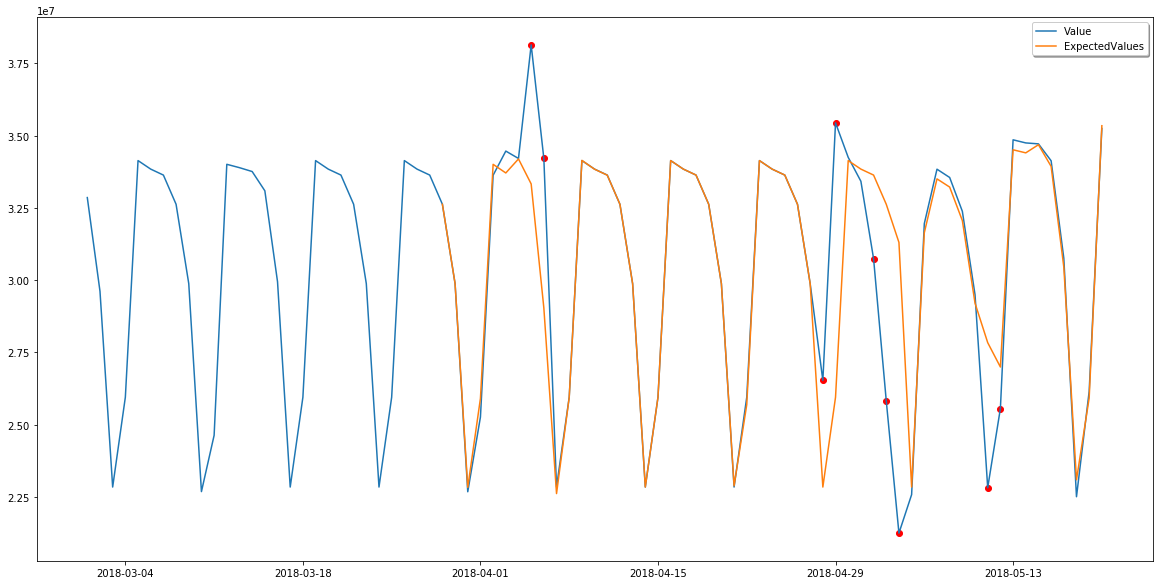

In [8]:
columns = {'ExpectedValues': result['ExpectedValues'], 'IsAnomaly': result['IsAnomaly'], 'IsAnomaly_Neg': result['IsNegativeAnomaly'],
              'IsAnomaly_Pos': result['IsPositiveAnomaly'], 'UpperMargins': result['UpperMargins'], 'LowerMargins': result['LowerMargins']
              , 'Value': [x['Value'] for x in sample_data['Series']], 'Timestamp': [parser.parse(x['Timestamp']) for x in sample_data['Series']]}
response = pd.DataFrame(data=columns)
sensitivity = 95 # you can change sensitivity here to tune upper and lower boundary
tune(sensitivity, response)